In [1]:
import numpy as np
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
class HiddenLayer:
    def __init__(self, initialWeights, initialBias, activationFunction):
        self.w = initialWeights # weights
        self.b = initialBias    # bias
        self.i = None           # input
        self.z = None           # output
        self.d = None           # delta
        self.a = None
        self.actFunc = activationFunction
    
    def copy(self):
        return HiddenLayer(self.w.copy(), self.b.copy(), self.actFunc)
    
    def forward(self, input):
        self.i = input
        self.z = np.dot(input, self.w.T) + self.b
        self.a = self.actFunc.f(self.z)
    
    def backward(self, nextLayerDelta, nextLayerWeights):
        self.d = np.dot(nextLayerDelta, nextLayerWeights) * self.actFunc.f_prime(self.z)
    
    def update(self, learningRate, lam):
        self.w -= learningRate * (np.dot(self.d.T, self.i) + lam * self.w)
        self.b -= learningRate * self.d.sum(axis=0)

class OutputLayer(HiddenLayer):
    def __init__(self, initialWeights, initialBias, activationFunction):
        super().__init__(initialWeights, initialBias, activationFunction)
    
    def copy(self):
        return OutputLayer(self.w.copy(), self.b.copy(), self.actFunc)
    
    def backward(self, target):
        self.d = (self.a - target) * self.actFunc.f_prime(self.z)

In [3]:
class ActivationSigmoid:
    def f(self, x):
        return 1 / (1 + np.exp(-x))
    
    def f_prime(self, x):
        return self.f(x) * (1 - self.f(x))
    
class ActivationReLU:
    def f(self, x):
        return np.maximum(0, x)
    
    def f_prime(self, x):
        return np.where(x > 0, 1, 0)

class ActivationTanh:
    def f(self, x):
        return np.tanh(x)
    
    def f_prime(self, x):
        return 1 - np.tanh(x) ** 2

In [4]:
class NeuralNetwork:
    def __init__(self, layers, learningRate):
        self.layers = layers
        self.learningRate = learningRate
        self.cost_over_time_training = None
        self.accuracy_over_time_training = None
        self.cost_over_time_validation = None
        self.accuracy_over_time_validation = None
    
    def copy(self):
        return NeuralNetwork([layer.copy() for layer in self.layers], self.learningRate)
    
    def forward(self, input):
        for layer in self.layers:
            layer.forward(input)
            input = layer.a
    
    def backward(self, target):
        for i in reversed(range(len(self.layers))):
            if i == len(self.layers) - 1:
                self.layers[i].backward(target)
            else:
                self.layers[i].backward(self.layers[i+1].d, self.layers[i+1].w)
    
    def update(self, learningRate, lam):
        for layer in self.layers:
            layer.update(learningRate, lam)
    
    def predict(self, input):
        self.forward(input)
        return self.layers[-1].a
    
    def cost(self, target, lam):
        mse = (0.5 / target.shape[0]) * np.sum((target - self.layers[-1].a)**2)
        l2_reg = 0.5 * lam * sum(np.sum(layer.w**2) for layer in self.layers[:-1])  # Exclude output layer
        return mse + l2_reg
    
    def accuracy(self, X, y):
        predictions = np.argmax(self.predict(X), axis=1)
        y_vals = np.argmax(y, axis=1)
        return np.mean(predictions == y_vals)
    
    def train(self, X, y, epochs, lam, X_val=None, y_val=None):
        self.cost_over_time_training = []
        self.accuracy_over_time_training = []
        if X_val is not None and y_val is not None:
            self.cost_over_time_validation = []
            self.accuracy_over_time_validation = []
        for i in range(epochs):
            if i % 100 == 0:
                print("Epoch", i)
            self.forward(X)
            self.backward(y)
            self.update(self.learningRate, lam)
            self.cost_over_time_training.append(self.cost(y, lam))
            self.accuracy_over_time_training.append(self.accuracy(X, y))
            if X_val is not None and y_val is not None:
                self.forward(X_val)
                self.cost_over_time_validation.append(self.cost(y_val, lam))
                self.accuracy_over_time_validation.append(self.accuracy(X_val, y_val))
    
    def graph_cost_over_time(self):
        # plots the cost over time for training and validation together
        plt.plot(self.cost_over_time_training, label="Training + Validation")
        if self.cost_over_time_validation is not None:
            plt.plot(self.cost_over_time_validation, label="Test")
        plt.title("Cost over time")
        plt.xlabel("Epochs")
        plt.ylabel("Cost")
        plt.legend()
        # show precise value for first and last epoch
        plt.annotate(str(round(self.cost_over_time_training[0], 4)), xy=(0, self.cost_over_time_training[0]))
        plt.annotate(str(round(self.cost_over_time_training[-1], 4)), xy=(len(self.cost_over_time_training)-1, self.cost_over_time_training[-1]))
        if self.cost_over_time_validation is not None:
            plt.annotate(str(round(self.cost_over_time_validation[0], 4)), xy=(0, self.cost_over_time_validation[0]))
            plt.annotate(str(round(self.cost_over_time_validation[-1], 4)), xy=(len(self.cost_over_time_validation)-1, self.cost_over_time_validation[-1]))
        plt.show()
        
    def graph_accuracy_over_time(self):
        plt.plot(self.accuracy_over_time_training, label="Training + Validation")
        if self.accuracy_over_time_validation is not None:
            plt.plot(self.accuracy_over_time_validation, label="Test")
        plt.title("Accuracy over time")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        # show precise value for first and last epoch
        plt.annotate(str(round(self.accuracy_over_time_training[0], 4)), xy=(0, self.accuracy_over_time_training[0]))
        plt.annotate(str(round(self.accuracy_over_time_training[-1], 4)), xy=(len(self.accuracy_over_time_training)-1, self.accuracy_over_time_training[-1]))
        if self.accuracy_over_time_validation is not None:
            plt.annotate(str(round(self.accuracy_over_time_validation[0], 4)), xy=(0, self.accuracy_over_time_validation[0]))
            plt.annotate(str(round(self.accuracy_over_time_validation[-1], 4)), xy=(len(self.accuracy_over_time_validation)-1, self.accuracy_over_time_validation[-1]))
        plt.show()
    
    def graph_cost_and_accuracy_over_time(self):
        # graph cost and accuracy next to each other
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.cost_over_time_training, label="Training + Validation")
        if self.cost_over_time_validation is not None:
            ax1.plot(self.cost_over_time_validation, label="Test")
        ax1.set_title("Cost over time")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Cost")
        ax1.legend()
        # show precise value for first and last epoch
        ax1.annotate(str(round(self.cost_over_time_training[0], 4)), xy=(0, self.cost_over_time_training[0]))
        ax1.annotate(str(round(self.cost_over_time_training[-1], 4)), xy=(len(self.cost_over_time_training)-1, self.cost_over_time_training[-1]))
        if self.cost_over_time_validation is not None:
            ax1.annotate(str(round(self.cost_over_time_validation[0], 4)), xy=(0, self.cost_over_time_validation[0]))
            ax1.annotate(str(round(self.cost_over_time_validation[-1], 4)), xy=(len(self.cost_over_time_validation)-1, self.cost_over_time_validation[-1]))
        
        ax2.plot(self.accuracy_over_time_training, label="Training + Validation")
        if self.accuracy_over_time_validation is not None:
            ax2.plot(self.accuracy_over_time_validation, label="Test")
        ax2.set_title("Accuracy over time")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        # show precise value for first and last epoch
        ax2.annotate(str(round(self.accuracy_over_time_training[0], 4)), xy=(0, self.accuracy_over_time_training[0]))
        ax2.annotate(str(round(self.accuracy_over_time_training[-1], 4)), xy=(len(self.accuracy_over_time_training)-1, self.accuracy_over_time_training[-1]))
        if self.accuracy_over_time_validation is not None:
            ax2.annotate(str(round(self.accuracy_over_time_validation[0], 4)), xy=(0, self.accuracy_over_time_validation[0]))
            ax2.annotate(str(round(self.accuracy_over_time_validation[-1], 4)), xy=(len(self.accuracy_over_time_validation)-1, self.accuracy_over_time_validation[-1]))
        
        plt.show()
    
    def print(self):
        for i, layer in enumerate(self.layers):
            print("Layer", i)
            print("Weights:\n", layer.w)
            print("Bias:\n", layer.b)
            print()

In [5]:
def BuildNetwork(structure, activation_function, initialization=np.zeros, learning_rate=0.1):
    layers = []
    for i in range(len(structure)-2):
        layers.append(HiddenLayer(
            initialization(structure[i+1], structure[i]),
            initialization(1, structure[i+1]),
            activation_function
        ))
    layers.append(OutputLayer(
        initialization(structure[-1], structure[-2]),
        initialization(1, structure[-1]),
        activation_function
    ))

    return NeuralNetwork(layers, learning_rate)

def ZerosInitialization(m, n):
    return np.zeros((m, n))

def UniformInitialization(m, n):
    limit = np.sqrt(6 / (m + n))
    return np.random.uniform(-limit, limit, (m, n))

def NormalInitialization(m, n):
    std = np.sqrt(2 / (m + n))
    return np.random.normal(0, std, (m, n))    

In [34]:
loaded = arff.loadarff('../connect-4.arff')

data = np.asarray(loaded[0].tolist(), dtype=np.float32)
X = data[:, :-1]
y = data[:, -1]

# extract the classes
X_zeros = X[y == 0]
y_zeros = y[y == 0]
X_ones = X[y == 1]
y_ones = y[y == 1]
X_twos = X[y == 2]
y_twos = y[y == 2]

max_from_each_class = min(X_zeros.shape[0], X_ones.shape[0], X_twos.shape[0])
print("max_from_each_class:", max_from_each_class)

# shuffle
np.random.seed(10)
X_zeros, y_zeros = shuffle(X_zeros, y_zeros)
X_ones, y_ones = shuffle(X_ones, y_ones)
X_twos, y_twos = shuffle(X_twos, y_twos)

# take only the first max_from_each_class elements
X_zeros = X_zeros[:max_from_each_class]
y_zeros = y_zeros[:max_from_each_class]
X_ones = X_ones[:max_from_each_class]
y_ones = y_ones[:max_from_each_class]
X_twos = X_twos[:max_from_each_class]
y_twos = y_twos[:max_from_each_class]

# split into train, test, and validation
X_zeros_train, X_zeros_testval, y_zeros_train, y_zeros_testval = train_test_split(X_zeros, y_zeros, test_size=0.2)
X_ones_train, X_ones_testval, y_ones_train, y_ones_testval = train_test_split(X_ones, y_ones, test_size=0.2)
X_twos_train, X_twos_testval, y_twos_train, y_twos_testval = train_test_split(X_twos, y_twos, test_size=0.2)
X_zeros_test, X_zeros_val, y_zeros_test, y_zeros_val = train_test_split(X_zeros_testval, y_zeros_testval, test_size=0.5)
X_ones_test, X_ones_val, y_ones_test, y_ones_val = train_test_split(X_ones_testval, y_ones_testval, test_size=0.5)
X_twos_test, X_twos_val, y_twos_test, y_twos_val = train_test_split(X_twos_testval, y_twos_testval, test_size=0.5)

# concatenate
X_train = np.concatenate((X_zeros_train[:max_from_each_class], X_ones_train[:max_from_each_class], X_twos_train[:max_from_each_class]), axis=0)
y_train = np.concatenate((y_zeros_train[:max_from_each_class], y_ones_train[:max_from_each_class], y_twos_train[:max_from_each_class]), axis=0)
X_test = np.concatenate((X_zeros_test[:max_from_each_class], X_ones_test[:max_from_each_class], X_twos_test[:max_from_each_class]), axis=0)
y_test = np.concatenate((y_zeros_test[:max_from_each_class], y_ones_test[:max_from_each_class], y_twos_test[:max_from_each_class]), axis=0)
X_val = np.concatenate((X_zeros_val[:max_from_each_class], X_ones_val[:max_from_each_class], X_twos_val[:max_from_each_class]), axis=0)
y_val = np.concatenate((y_zeros_val[:max_from_each_class], y_ones_val[:max_from_each_class], y_twos_val[:max_from_each_class]), axis=0)

# one hot encoding
y_train = np.eye(3)[y_train.astype(int)]
y_test = np.eye(3)[y_test.astype(int)]
y_val = np.eye(3)[y_val.astype(int)]
# convert 2s to -1s
X_train[X_train == 2] = -1
X_test[X_test == 2] = -1
X_val[X_val == 2] = -1

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

max_from_each_class: 6449
X_train: (15477, 42)
y_train: (15477, 3)
X_test: (1935, 42)
y_test: (1935, 3)
X_val: (1935, 42)
y_val: (1935, 3)


In [7]:
def TrainNetworks(networks, epochs, lams=[0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):
    network_best_accuracy = [0 for _ in networks]
    network_best_accuracy_lambda = [None for _ in networks]
    network_best_accuracy_model = [None for _ in networks]
    for i, network in enumerate(networks):
        print("Training network", i+1)
        for lam in lams:
            net = network.copy()
            print("Lambda:", lam, end="... ")
            net.train(X_train, y_train, epochs, lam, X_test, y_test)
            acc = net.accuracy(X_test, y_test)
            print("Accuracy:", acc)
            if acc > network_best_accuracy[i]:
                network_best_accuracy[i] = acc
                network_best_accuracy_lambda[i] = lam
                network_best_accuracy_model[i] = net
        print("Best accuracy:", network_best_accuracy[i], "with lambda", network_best_accuracy_lambda[i], "\n")
        network_best_accuracy_model[i].graph_accuracy_over_time()
    # get index of best accuracy
    best_network_index = network_best_accuracy.index(max(network_best_accuracy))
    print("Best network is network", best_network_index+1, "with accuracy", network_best_accuracy[best_network_index], "and lambda", network_best_accuracy_lambda[best_network_index])
    return network_best_accuracy_model[best_network_index]

Training network 1
Lambda: 10... Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900
Epoch 5000
Epoch 5100
Epoch 5200
Epoch 5300
Epoch 5400
Epoch 5500
Epoch 5600
Epoch 5700
Epoch 5800
Epoch 5900
Epoch 6000
Epoch 6100
Epoch 6200
Epoch 6300
Epoch 6400
Epoch 6500
Epoch 6600
Epoch 6700
Epoch 6800
Epoch 6900
Epoch 7000
Epoch 7100
Epoch 7200
Epoch 7300
Epoch 7400
Epoch 7500
Epoch 7600
Epoch 7700
Epoch 7800
Epoch 7900
Epoch 8000
Epoch 8100
Epoch 8200
Epoch 8300
Epoch 8400
Epoch 8500
Epoch 8600
Epoch 8700
Epoch 8800


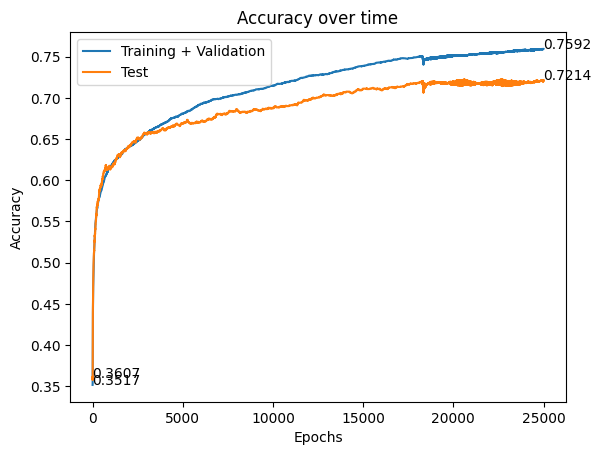

Best network is network 1 with accuracy 0.7214470284237726 and lambda 10


In [8]:
layers = [[42, 30, 15, 15, 3]]
activations = [ActivationTanh()]
initializations = [NormalInitialization]

networks = []
for layer in layers:
    for activation in activations:
        for initialization in initializations:
            networks.append(BuildNetwork(layer, activation, initialization, 5e-6))

# combine training and validation
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)
network = TrainNetworks(networks, 25000, lams=[10])


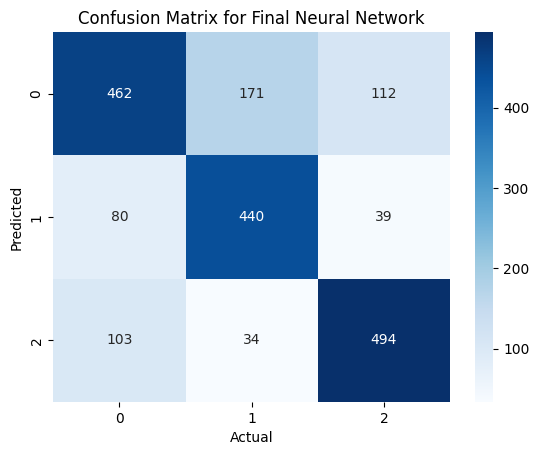

In [37]:
import seaborn as sns

# make a confusion matrix and plot it
y_pred = network.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
confusion_matrix = np.zeros((3, 3), dtype=int)
for i in range(len(y_pred)):
    confusion_matrix[y_pred[i]][y_test[i]] += 1
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix for Final Neural Network")
plt.show()

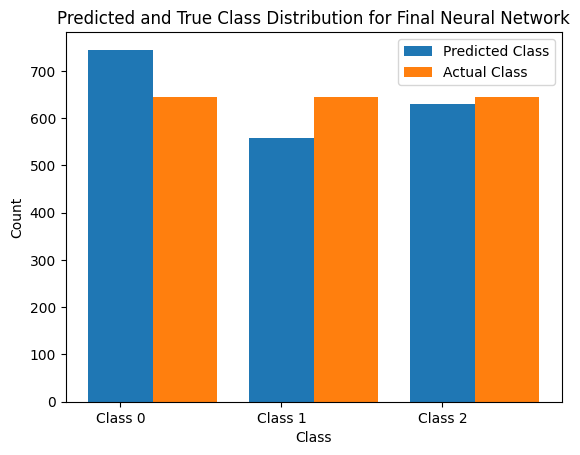

In [40]:
# Define the number of bins and bin edges
n_bins = 3
bin_edges = np.arange(n_bins + 1)

# Count the frequency of each predicted class and true class
hist_pred, _ = np.histogram(y_pred, bins=bin_edges)
hist_test, _ = np.histogram(y_test, bins=bin_edges)

# Create the histogram with two bars for each class
fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], hist_pred, width=0.4, align='edge', label='Predicted Class')
ax.bar(bin_edges[:-1] + 0.4, hist_test, width=0.4, align='edge', label='Actual Class')
ax.set_xticks(bin_edges[:-1] + 0.2)
ax.set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Predicted and True Class Distribution for Final Neural Network')
ax.legend()
plt.show()